In [1]:
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn
import matplotlib.pyplot as pyplot
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import pandas
import numpy
import wandb
from wandb.keras import WandbCallback

wandb.login(key='ea1404a9d16ac9056181f111599286f24c65e0e9')
wandb.init(project='covid19', entity='ashuto7h')
config = wandb.config


2021-11-12 18:45:23.066844: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ashuto7h (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-11-12 18:45:30.716380: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [2]:
# ! pip install tensorflow --upgrade


In [3]:
sdir = r'../input/large-covid19-ct-slice-dataset/curated_data/curated_data'
filepaths = []
labels = []
classlist = os.listdir(sdir)
for item in classlist:
    classpath = os.path.join(sdir, item)
    flist = os.listdir(classpath)
    for f in flist:
        fpath = os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(item)

df = pandas.DataFrame()
df['filepath'] = filepaths
df['labels'] = labels
print(df['labels'].value_counts())
df = df.sample(frac=1).reset_index(drop=True)


2COVID       7593
1NonCOVID    6893
3CAP         2618
Name: labels, dtype: int64


In [4]:
df


,filepath,labels
0,../input/large-covid19-ct-slice-dataset/curate...,1NonCOVID
1,../input/large-covid19-ct-slice-dataset/curate...,2COVID
2,../input/large-covid19-ct-slice-dataset/curate...,2COVID
3,../input/large-covid19-ct-slice-dataset/curate...,3CAP
4,../input/large-covid19-ct-slice-dataset/curate...,2COVID
...,...,...
17099,../input/large-covid19-ct-slice-dataset/curate...,1NonCOVID
17100,../input/large-covid19-ct-slice-dataset/curate...,2COVID
17101,../input/large-covid19-ct-slice-dataset/curate...,2COVID
17102,../input/large-covid19-ct-slice-dataset/curate...,1NonCOVID


In [5]:
cw = compute_class_weight('balanced', classes=df.labels.unique(), y=df.labels)
print(cw, df.labels.unique())


[0.8271193  0.75086703 2.17774382] ['1NonCOVID' '2COVID' '3CAP']


In [6]:
class_weights = {2: 2.17774382, 0: 0.8271193, 1: 0.75086703}
class_map = {'2COVID': 1, '1NonCOVID': 0, '3CAP': 2}


In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, color_mode="rgb"):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()
        self.color_mode = color_mode
        self.augmentor = keras.preprocessing.image.ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            brightness_range=[0, 0.2])

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index *
                           self.batch_size:(index + 1) *
                           self.batch_size]
        batch = [self.indices[k] for k in index]

        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = numpy.arange(len(self.indices))
        if self.shuffle == True:
            numpy.random.shuffle(self.index)

    def __get_data(self, batch):
        X = []
        y = []
        for i, id in enumerate(batch):
            img = tf.keras.preprocessing.image.load_img(
                self.df.loc[id, 'filepath'],
                color_mode=self.color_mode,
                target_size=(256, 256),
                interpolation="nearest")
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            X.append(img_array/255)
            ylist = [0, 0, 0]
            ylist[class_map[self.df.loc[id, 'labels']]] = 1
            ylist = numpy.array(ylist)
            y.append(ylist)
        X = numpy.array(X)
        X = self.augmentor.flow(
            X, batch_size=self.batch_size, shuffle=False).next()
        y = numpy.array(y)
        return X, y


In [8]:
train_data = DataGenerator(df[:13684].reset_index(drop=True))  # 80%
valid_data = DataGenerator(df[13684:15394].reset_index(drop=True))  # 80 - 90%
test_data = DataGenerator(df[15394:].reset_index(
    drop=True), shuffle=False)  # 90 - 100%

# train_data = DataGenerator(df[:200].reset_index(drop=True))  # 80%
# valid_data = DataGenerator(df[200:300].reset_index(drop=True))  # 80 - 90%
# test_data = DataGenerator(df[300:400].reset_index(drop=True), shuffle=False)  # 90 - 100%


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization


def build_model():
    inputs = layers.Input(shape=(256, 256, 3))
    x = ResNet50(include_top=False, weights='imagenet',
                 input_shape=(256, 256, 3))(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
#     x = BatchNormalization()(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [10]:
initial_learning_rate = 0.015
epochs = 100
model_name = "Resnet_v13.h5"
patience = 10
decay_steps = 100000
decay_rate = 0.96

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    model_name,
    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience,
    restore_best_weights=True)


In [11]:
config.class_weights = class_weights
config.class_map = class_map
config.initial_learning_rate = initial_learning_rate
config.epochs = epochs
config.model_name = model_name
config.patience = patience
config.decay_steps = decay_steps
config.decay_rate = decay_rate
# config.pooling = 'max'


In [12]:
model = build_model()
wandb.log({'model_summary': model.summary()})
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=epochs,
    class_weight=class_weights,
    verbose=1,
    validation_data=valid_data,
    workers=2,
    callbacks=[checkpoint_cb, early_stopping_cb, WandbCallback()],
)


2021-11-12 18:45:44.359445: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-12 18:45:44.362882: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-12 18:45:44.400346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 18:45:44.400967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-12 18:45:44.401051: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-12 18:45:44.431292: I tensorflow/stream_executor/platform/def

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,602,051
Trainable params: 23,544,835
Non-trai

2021-11-12 18:45:49.668669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-12 18:45:49.673021: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/100


2021-11-12 18:45:55.552645: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-12 18:45:56.570841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-12 18:45:56.621507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


427/427 [==============================] - 157s 338ms/step - loss: 2.5014 - accuracy: 0.4426 - precision: 0.4504 - recall: 0.4080 - val_loss: 1.7183 - val_accuracy: 0.4080 - val_precision: 0.4080 - val_recall: 0.4080
Epoch 2/100
427/427 [==============================] - 111s 259ms/step - loss: 1.1573 - accuracy: 0.5598 - precision: 0.5871 - recall: 0.4935 - val_loss: 31.2851 - val_accuracy: 0.4511 - val_precision: 0.4502 - val_recall: 0.4481
Epoch 3/100
427/427 [==============================] - 110s 257ms/step - loss: 0.9904 - accuracy: 0.5905 - precision: 0.6321 - recall: 0.5016 - val_loss: 0.9878 - val_accuracy: 0.4623 - val_precision: 1.0000 - val_recall: 0.0631
Epoch 4/100
427/427 [==============================] - 110s 257ms/step - loss: 0.8914 - accuracy: 0.6167 - precision: 0.6606 - recall: 0.5196 - val_loss: 237.7519 - val_accuracy: 0.3785 - val_precision: 0.3788 - val_recall: 0.3785
Epoch 5/100
427/427 [==============================] - 110s 258ms/step - loss: 0.8647 - accur

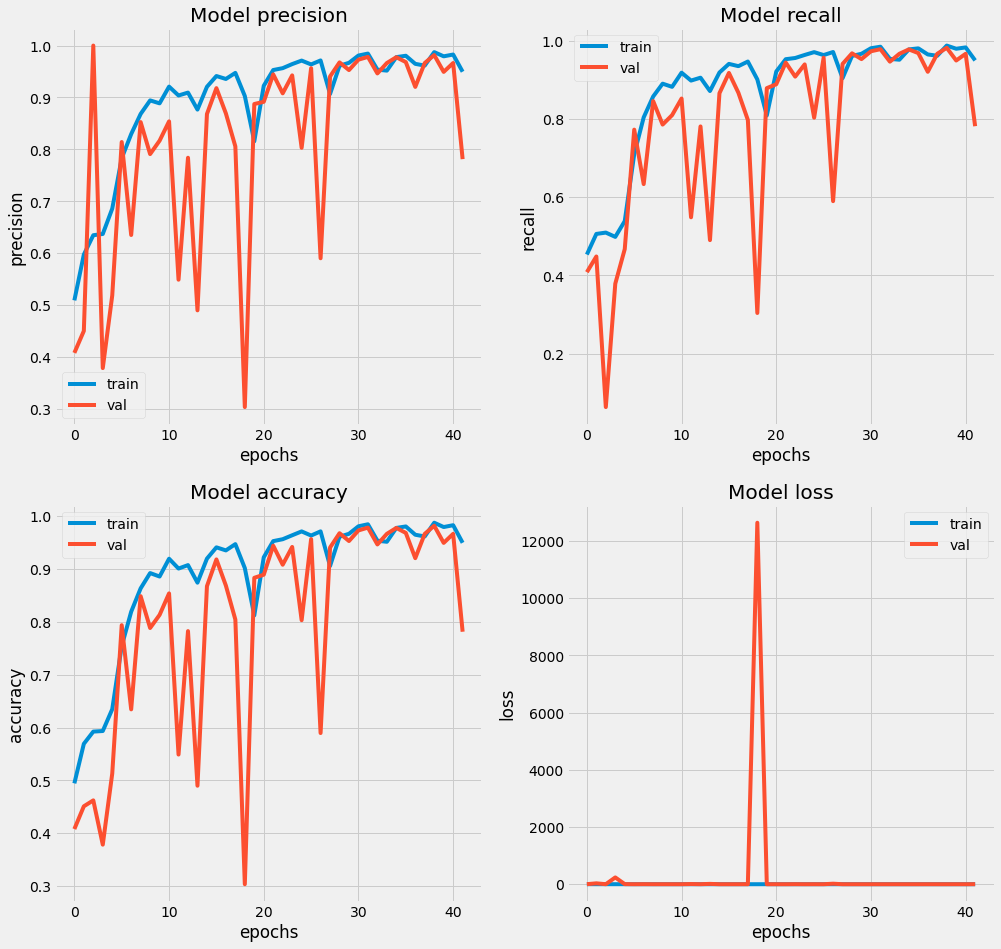

In [13]:
pyplot.style.use('fivethirtyeight')
fig, ax = pyplot.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])
try:
    wandb.log({'training log img': wandb.Image(fig)})
except:
    pass


In [14]:
train_eval = model.evaluate(train_data, return_dict=True)
wandb.log({'train evaluation': train_eval})
display('train evaluation', train_eval)

valid_eval = model.evaluate(valid_data, return_dict=True)
wandb.log({'valid evaluation': valid_eval})
display('valid evaluation', valid_eval)

test_eval = model.evaluate(test_data, return_dict=True)
wandb.log({'test evaluation': test_eval})
display('test evaluation', test_eval)


427/427 [==============================] - 94s 219ms/step - loss: 0.0260 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906


'train evaluation'

{'loss': 0.025975653901696205,
 'accuracy': 0.9906322956085205,
 'precision': 0.9906322956085205,
 'recall': 0.9906322956085205}

53/53 [==============================] - 11s 208ms/step - loss: 0.0853 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782


'valid evaluation'

{'loss': 0.08528900146484375,
 'accuracy': 0.9781839847564697,
 'precision': 0.9781839847564697,
 'recall': 0.9781839847564697}

53/53 [==============================] - 27s 522ms/step - loss: 0.0787 - accuracy: 0.9764 - precision: 0.9770 - recall: 0.9764


'test evaluation'

{'loss': 0.07874119281768799,
 'accuracy': 0.9764150977134705,
 'precision': 0.9769911766052246,
 'recall': 0.9764150977134705}

In [15]:


def get_class(value):
    for key in class_map.keys():
        if class_map[key] == value:
            return key


get_class(2)


'3CAP'

### Confusion matrix - validation


53/53 [==============================] - 12s 212ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       696
           1       0.98      0.97      0.98       756
           2       1.00      1.00      1.00       244

    accuracy                           0.98      1696
   macro avg       0.98      0.98      0.98      1696
weighted avg       0.98      0.98      0.98      1696



<AxesSubplot:>

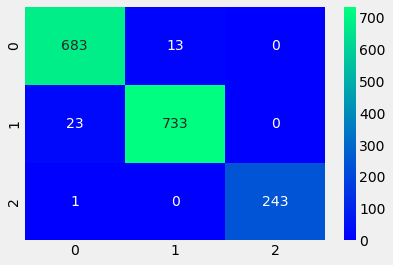

In [16]:

labels = []
for image, label in valid_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(valid_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix valid img': wandb.Image(x)})
except:
    pass
display(x)


In [17]:

labels = []
for image, label in test_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(test_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)


53/53 [==============================] - 11s 210ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       681
           1       0.98      0.97      0.97       750
           2       1.00      1.00      1.00       265

    accuracy                           0.98      1696
   macro avg       0.98      0.98      0.98      1696
weighted avg       0.98      0.98      0.98      1696



<AxesSubplot:>

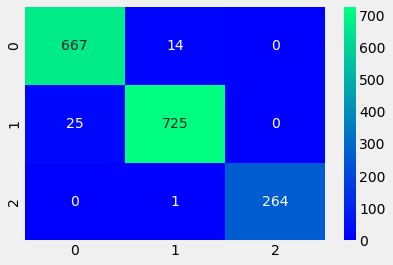

In [18]:
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix test img': wandb.Image(x)})
except:
    pass
display(x)
